In [18]:
paths = [".."]
import sys
for path in paths:
    if path not in sys.path:
        sys.path.append(path)
from nf_slam.cnf.odometry import CNFOdometry
from nf_slam.cnf.mapping import CNFMapBuilder, CNFMapBuildingConfig, RectangleBoundary, CNFMapModelConfig
from nf_slam.lidar_dataset_loader import LidarDatasetLoader, LidarDatasetLoaderConfig
from nf_slam.plotting_utils import show_points

import matplotlib.pyplot as plt
from clearml import Task
import numpy as np
import jax.numpy as jnp

# Init ClearMl task

In [10]:
task = Task.init(project_name='nf_2d_odometry', task_name='classification_map_odometry')

ClearML Task: created new task id=795e88e07dd44de582ad0c18127b9491
======> WARNING! Git diff to large to store (980kb), skipping uncommitted changes <======
ClearML results page: https://app.community.clear.ml/projects/b9af10ab900a449ebf2af1017b6bc3ad/experiments/795e88e07dd44de582ad0c18127b9491/output/log
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


In [11]:
lidar_dataset_loader_config = LidarDatasetLoaderConfig(
    maximal_token_length=180,
    minimal_angle=90.,
    maximal_angle=90.,
    maximal_distance=10.
)
dataset_loader = LidarDatasetLoader(lidar_dataset_loader_config)

In [12]:
datafile = "/home/mikhail/Downloads/intel.gfs(4).log" 
datafile = "/home/mikhail/Downloads/intel.log"
laser_data_list = dataset_loader.load(datafile)

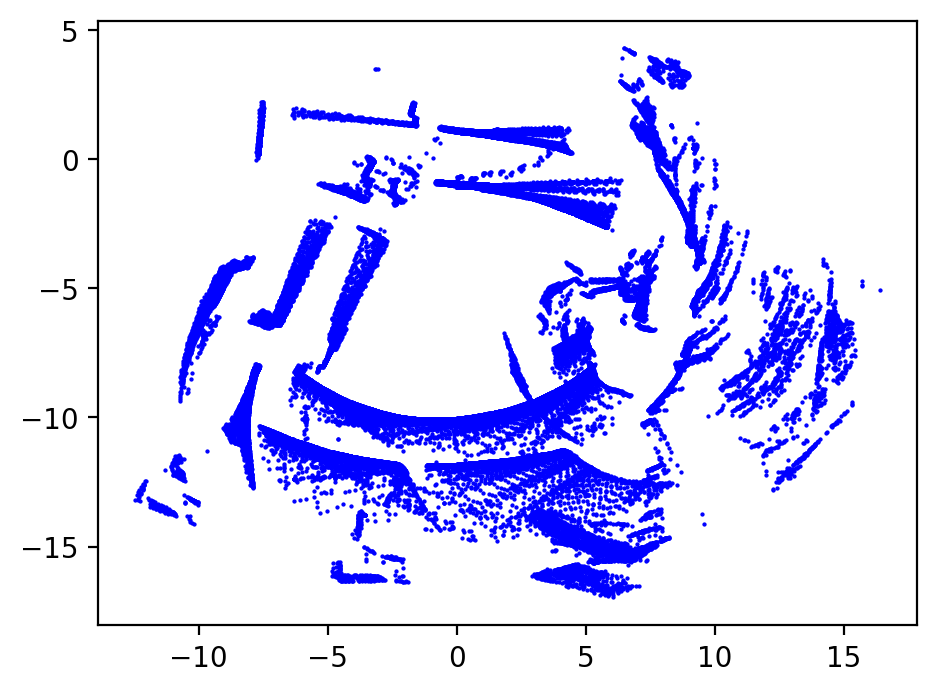

In [15]:
plt.figure(dpi=200)
show_points(laser_data_list[0:1000:2], c="blue");

# NF Odometry

In [20]:
parameters = {
        'mlp_model': {
            "type": "MLPModel",
        },
        'map_model_config': {
            'type': "CNFMapModelConfig",
            'minimal_depth': 0.05,
            'maximal_depth': 10,
            'F': 4,
            'L': 16,
            'T': 4096,
            'min_log_resolution': -0.5,
            'max_log_resolution': 2.,
        },
        'learning_config': {
            "type": "LearningConfig",
            'iterations': 100,
            'variable_optimizer_config': {
                'learning_rate': 2e-2,
                'beta1': 0.9,
                'beta2': 0.99,
                'eps': 1e-15,
                'weight_decay': 1e-6
            },
            'hashtable_optimizer_config': {
                'learning_rate': 2e-2,
                'beta1': 0.9,
                'beta2': 0.99,
                'eps': 1e-15,
                'weight_decay': 0
            }
        },
        'map_building_config': {
            "type": "CNFMapBuildingConfig",
            'sampling_depth_delta': 3.,
            'sampling_depth_count': 200,
            'point_loss_weight': 1.,
            'classification_loss_weight': 1.,
            'random_point_loss_weight': 100.,
            'random_point_count': 100,
            "random_point_boundary": RectangleBoundary(*np.array([0, 10, 0, 10]))
        },
        'cnf_odometry': {
            "type": "CNFOdometry",
            "parameters": {
                'tracking_iterations': 2,
                'mapping_iterations': 2,
                'batch_mapping_iterations': 2,
                'mapping_batch_count': 5,
                'point_count': 200
            },
            "batch_map_builder": {},
            "position_optimizer": {
                "config": {
                    'learning_rate': 0.9,
                    'iterations': 100,
                    'init_hessian': jnp.diag(jnp.array([200, 200, 200])),
                    'maximal_clip_norm': 100,
                    'beta1': 0.5,
                    'beta2': 0.3,
                    'hessian_adder': jnp.diag(jnp.array([200, 200, 200])) * 0.1,
                    'tracking_config': {'huber_scale': 0.3}
                }
            },
            "map_builder": {}
        }
    }
task.connect(parameters);

2022-08-18 21:12:03,349 - clearml.Task - WARNING - Skipping parameter: General/map_building_config/random_point_boundary[RectangleBoundary], General/cnf_odometry/position_optimizer/config/init_hessian[DeviceArray], General/cnf_odometry/position_optimizer/config/hessian_adder[DeviceArray], only builtin types are supported (tuple, str, int, list, NoneType, dict, float)


In [21]:
task.close()

2022-08-18 21:14:05,638 - clearml.Task - INFO - Waiting to finish uploads
2022-08-18 21:14:10,003 - clearml.Task - INFO - Finished uploading
